In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs
import os
import tensorflow as tf

# Load your SMILES CSV
csv_path = "/Users/devanshjain/laboratoire_d_intelligence_artificielle_en_chimie/3ttz/sampling_TRANSFER.csv"  # change to your file
df = pd.read_csv(csv_path)
df = df[df["SMILES"].notna()].copy()
df["mol"] = df["SMILES"].apply(Chem.MolFromSmiles)
df = df[df["mol"].notna()].copy()

# Morgan fingerprints to numpy arrays
def mol_to_fp_array(mol, radius=2, nBits=1024):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

X = np.vstack(df["mol"].apply(mol_to_fp_array))

# Output folder for TensorBoard logs
log_dir = "tb_mol_logs"
os.makedirs(log_dir, exist_ok=True)

# Save embeddings tensor
embeddings_var = tf.Variable(X, name="molecule_embeddings")

# Write SMILES as metadata
meta_file = os.path.join(log_dir, "metadata.tsv")
df["SMILES"].to_csv(meta_file, sep="\t", index=False, header=False)

# Optional: Save molecule images
sprite_size = 64
imgs = [Draw.MolToImage(m, size=(sprite_size, sprite_size)) for m in df["mol"]]
# Combine into a sprite image
from PIL import Image
n = int(np.ceil(np.sqrt(len(imgs))))
sprite = Image.new("RGB", (sprite_size*n, sprite_size*n), (255,255,255))
for i, img in enumerate(imgs):
    row = i // n
    col = i % n
    sprite.paste(img, (col*sprite_size, row*sprite_size))
sprite_file = os.path.join(log_dir, "sprite.png")
sprite.save(sprite_file)

# Configure projector
from tensorboard.plugins import projector
checkpoint = tf.train.Checkpoint(embedding=embeddings_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "molecule_embeddings/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = "metadata.tsv"
embedding.sprite.image_path = "sprite.png"
embedding.sprite.single_image_dim.extend([sprite_size, sprite_size])

projector.visualize_embeddings(log_dir, config)


In [2]:
from pymol import cmd
import numpy as np

# === USER EDITABLE ===
pdb_path = "3TTZ.pdb"    # adjust if your file is named differently or give full path
ligand_resn = "07N"      # ligand residue name
ligand_chain = "A"       # target chain context if needed (for clarity)
margin = 5.0             # Å padding on each side
# ======================

# Load structure
cmd.reinitialize()
cmd.load(pdb_path, "target")

# Select ligand; some PDBs have the ligand not on chain A, so we just target resn
sel_lig = f"resn {ligand_resn}"
cmd.select("ligand", sel_lig)

# Fallback: if ligand has multiple models/alt conformers, take first state
coords = np.array(cmd.get_coords("ligand"))

if coords.size == 0:
    print(f"ERROR: No atoms found for ligand selection '{sel_lig}'. Check residue name and file.")
else:
    # Center of ligand (could override with your given point if desired)
    center = coords.mean(axis=0)
    dims = coords.max(axis=0) - coords.min(axis=0)  # extent of ligand
    size = dims + 2 * margin  # add margin on both sides

    # Vina expects size_x/y/z as extents; round reasonably
    center_x, center_y, center_z = center
    size_x, size_y, size_z = size

    print("AutoDock Vina search_space parameters (rounded to 3 decimals):")
    print(f"--center_x {center_x:.3f}")
    print(f"--center_y {center_y:.3f}")
    print(f"--center_z {center_z:.3f}")
    print(f"--size_x {size_x:.3f}")
    print(f"--size_y {size_y:.3f}")
    print(f"--size_z {size_z:.3f}")

    # Also echo JSON-ready fragment
    print("\nJSON snippet for REINVENT config:")
    print("{")
    print(f'  "--center_x": {center_x:.3f},')
    print(f'  "--center_y": {center_y:.3f},')
    print(f'  "--center_z": {center_z:.3f},')
    print(f'  "--size_x": {size_x:.3f},')
    print(f'  "--size_y": {size_y:.3f},')
    print(f'  "--size_z": {size_z:.3f}')
    print("}")


ModuleNotFoundError: No module named 'pymol'

Loaded 19 REINVENT molecules.
Generated 19 decoy molecules.


Docking reinvent:  11%|█████▋                                                | 2/19 [00:00<00:01, 14.67it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9b_qtigt/lig_0.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9b_qtigt/lig_0.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpcpreoiq5/lig_1.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpcpreoiq5/lig_1.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp1xg8fkci/lig_2.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp1xg8fkci/lig_2.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking reinvent:  21%|███████████▎                                          | 4/19 [00:00<00:01, 12.02it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpgaegdzze/lig_3.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpgaegdzze/lig_3.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpa0opm6gl/lig_4.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpa0opm6gl/lig_4.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp6x53vjv0/lig_5.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp6x53vjv0/lig_5.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpehv7djjv/lig_6.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpehv7djjv/lig_6.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpw5nli6fh/lig_7.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpw5nli6fh/lig_7.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking reinvent:  47%|█████████████████████████▌                            | 9/19 [00:00<00:00, 24.22it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmprrftwsz5/lig_8.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmprrftwsz5/lig_8.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpwq6_hmxq/lig_9.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpwq6_hmxq/lig_9.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpxfd0zi3o/lig_10.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpxfd0zi3o/lig_10.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpk_nn5b2p/lig_11.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpk_nn5b2p/lig_11.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking reinvent:  68%|████████████████████████████████████▎                | 13/19 [00:00<00:00, 27.57it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp6gddo0mk/lig_12.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp6gddo0mk/lig_12.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmptqlv1zmy/lig_13.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmptqlv1zmy/lig_13.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpyp6kdsb8/lig_14.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpyp6kdsb8/lig_14.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking reinvent:  89%|███████████████████████████████████████████████▍     | 17/19 [00:00<00:00, 25.75it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpukviy_5s/lig_15.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpukviy_5s/lig_15.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp0g2mw8p0/lig_16.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp0g2mw8p0/lig_16.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpwzr72gzg/lig_17.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpwzr72gzg/lig_17.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking reinvent: 100%|█████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.51it/s]


[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp1g19r2vh/lig_18.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp1g19r2vh/lig_18.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy:  11%|██████                                                   | 2/19 [00:00<00:00, 19.02it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp_ycvlph_/lig_0.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp_ycvlph_/lig_0.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpo9tqhq6e/lig_1.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpo9tqhq6e/lig_1.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpm8ond_ne/lig_2.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpm8ond_ne/lig_2.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy:  21%|████████████                                             | 4/19 [00:00<00:01, 13.17it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpy3ml5o4j/lig_3.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpy3ml5o4j/lig_3.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp8tfqan03/lig_4.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp8tfqan03/lig_4.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpq1aw7jum/lig_5.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpq1aw7jum/lig_5.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp01nrgss4/lig_6.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp01nrgss4/lig_6.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpo4qkb9au/lig_7.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpo4qkb9au/lig_7.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy:  47%|███████████████████████████                              | 9/19 [00:00<00:00, 25.76it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9qv8kbys/lig_8.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9qv8kbys/lig_8.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmphwgb6wsm/lig_9.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmphwgb6wsm/lig_9.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpz8ki7wp5/lig_10.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpz8ki7wp5/lig_10.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpud52cf74/lig_11.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpud52cf74/lig_11.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy:  68%|██████████████████████████████████████▎                 | 13/19 [00:00<00:00, 28.43it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpbfsakrh0/lig_12.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpbfsakrh0/lig_12.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpv5wds1ro/lig_13.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpv5wds1ro/lig_13.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpntf_x0ww/lig_14.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpntf_x0ww/lig_14.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy:  89%|██████████████████████████████████████████████████      | 17/19 [00:00<00:00, 25.29it/s]

[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmphr17_3zw/lig_15.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmphr17_3zw/lig_15.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9xccyqni/lig_16.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmp9xccyqni/lig_16.pdbqt (e.g., via MGLTools prepare_ligand4.py)
[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpk2e1zcqw/lig_17.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmpk2e1zcqw/lig_17.pdbqt (e.g., via MGLTools prepare_ligand4.py)


Docking decoy: 100%|████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.64it/s]


[!] Convert /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmptvb3ims6/lig_18.sdf -> /var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/tmptvb3ims6/lig_18.pdbqt (e.g., via MGLTools prepare_ligand4.py)


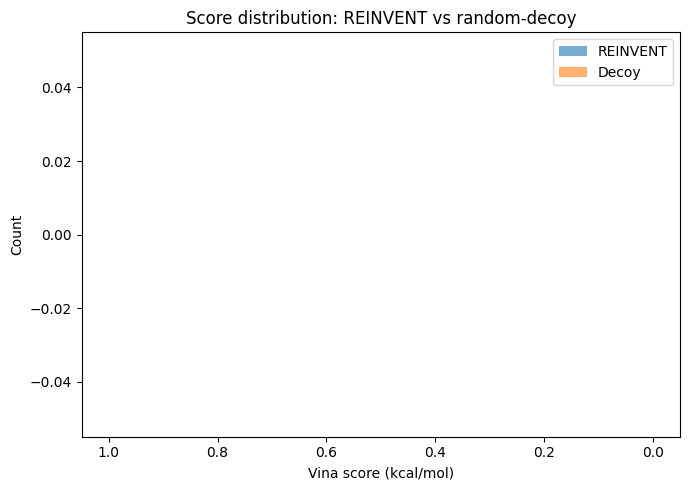

REINVENT stats: {'mean': np.float64(nan), 'median': np.float64(nan), 'std': np.float64(nan), 'n': 0}
Decoy stats: {'mean': np.float64(nan), 'median': np.float64(nan), 'std': np.float64(nan), 'n': 0}


/var/folders/jv/219p6n9s5ll8vv2nm1whxw340000gn/T/ipykernel_30095/912278595.py:179: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(arr),
/Users/devanshjain/miniconda3/envs/reinvent4/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/devanshjain/miniconda3/envs/reinvent4/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [2]:
import os
import subprocess
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Draw
from tqdm import tqdm

# === USER CONFIGURATION ===
reinvent_smiles_csv = "/Users/devanshjain/laboratoire_d_intelligence_artificielle_en_chimie/3ttz/3ttz_smiles_rand_trans.csv"   # your REINVENT output with column 'smiles'
receptor_pdbqt = "/Users/devanshjain/3ttz_chainA_receptor.pdb"              # prepared receptor
vina_binary = "/Users/devanshjain/Downloads/autodock_vina_1_1_2_mac_catalina_64bit/bin"                  # path to AutoDock Vina executable
out_dir = "/Users/devanshjain/laboratoire_d_intelligence_artificielle_en_chimie/3ttz/docking_comparison"
os.makedirs(out_dir, exist_ok=True)

# docking box (example; replace with your actual box)
search_space = {
    "--center_x": 0.467143,
    "--center_y": 3.288929,
    "--center_z": 24.798214,
    "--size_x": 20,
    "--size_y": 20,
    "--size_z": 20,
}

# number of poses to request
num_poses = 1

# === HELPERS ===

def load_smiles(path):
    df = pd.read_csv(path)
    if "smiles" not in df.columns:
        raise KeyError("CSV must have a 'smiles' column")
    df = df.dropna(subset=["smiles"]).copy()
    df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notna()].reset_index(drop=True)
    return df

def randomize_smiles(smiles):
    """Basic decoy: shuffle atom order of a valid molecule to break chemotype coherence."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # randomize atom ordering
    perm = list(range(mol.GetNumAtoms()))
    np.random.shuffle(perm)
    new = Chem.RenumberAtoms(mol, perm)
    return Chem.MolToSmiles(new, canonical=False)

def prepare_conformer(mol, energy_iter=200):
    m2 = Chem.AddHs(mol)
    AllChem.EmbedMolecule(m2, randomSeed=42)
    AllChem.UFFOptimizeMolecule(m2, maxIters=energy_iter)
    AllChem.RemoveHs(m2)
    return m2

def write_sdf(mol, path, name="lig"):
    mol.SetProp("_Name", name)
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()

def run_vina(lig_pdbqt, receptor_pdbqt, out_pdbqt, log_path, box):
    cmd = [
        vina_binary,
        "--receptor", receptor_pdbqt,
        "--ligand", lig_pdbqt,
        "--out", out_pdbqt,
        "--log", log_path,
        "--num_modes", str(num_poses),
        "--exhaustiveness", "8",  # adjustable
    ]
    for k, v in box.items():
        cmd += [k, str(v)]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Vina error: {result.stderr.strip()}")
    return result.stdout + "\n" + result.stderr

def extract_best_score(vina_log):
    # parse something like: "1        -8.5      0.000      0.000"
    for line in vina_log.splitlines():
        if line.strip().startswith("1 "):
            parts = line.split()
            try:
                return float(parts[1])
            except:
                pass
    # fallback: search for "affinity:" etc.
    return np.nan

def convert_sdf_to_pdbqt(sdf_path, pdbqt_path):
    # This assumes you have prepare_ligand4.py or use obabel; placeholder:
    # User should replace with their own converter, e.g., using MGLTools:
    raise NotImplementedError("Convert SDF to PDBQT with your preferred tool (e.g., MGLTools prepare_ligand4.py)")

# === MAIN WORKFLOW ===

# Step 1: load REINVENT smiles
reinvent_df = load_smiles(reinvent_smiles_csv)
n = len(reinvent_df)
print(f"Loaded {n} REINVENT molecules.")

# Step 2: construct decoys by randomizing atom order
decoy_smiles = []
for s in reinvent_df["smiles"]:
    rs = randomize_smiles(s)
    if rs is not None:
        decoy_smiles.append(rs)
decoy_df = pd.DataFrame({"smiles": decoy_smiles[:n]})
decoy_df["mol"] = decoy_df["smiles"].apply(Chem.MolFromSmiles)
decoy_df = decoy_df[decoy_df["mol"].notna()].reset_index(drop=True)
print(f"Generated {len(decoy_df)} decoy molecules.")

# Function to process a dataset (reinvent or decoy)
def dock_dataset(df, tag):
    scores = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Docking {tag}"):
        smiles = row["smiles"]
        mol = row["mol"]
        try:
            conf = prepare_conformer(mol)
        except Exception as e:
            print(f"Failed embedding for {smiles}: {e}")
            continue
        # write temporary SDF
        with tempfile.TemporaryDirectory() as td:
            sdf_path = os.path.join(td, f"lig_{idx}.sdf")
            write_sdf(conf, sdf_path, name=f"{tag}_{idx}")
            # User must convert sdf to pdbqt externally or plug in your converter here.
            pdbqt_lig = os.path.join(td, f"lig_{idx}.pdbqt")
            # Placeholder: user should replace with actual conversion command/script
            print(f"[!] Convert {sdf_path} -> {pdbqt_lig} (e.g., via MGLTools prepare_ligand4.py)")
            if not os.path.exists(pdbqt_lig):
                # skip docking if not available
                scores.append(np.nan)
                continue
            out_pdbqt = os.path.join(out_dir, f"{tag}_docked_{idx}.pdbqt")
            log_file = os.path.join(out_dir, f"{tag}_vina_{idx}.log")
            vina_output = run_vina(pdbqt_lig, receptor_pdbqt, out_pdbqt, log_file, search_space)
            sc = extract_best_score(vina_output)
            scores.append(sc)
    return np.array(scores, dtype=float)

# Dock both sets (user must supply converted PDBQT ligands or integrate converter)
reinvent_scores = dock_dataset(reinvent_df, "reinvent")
decoy_scores = dock_dataset(decoy_df, "decoy")

# Compile results
res_df = pd.DataFrame({
    "smiles": list(reinvent_df["smiles"]) + list(decoy_df["smiles"]),
    "type": ["reinvent"] * len(reinvent_scores) + ["decoy"] * len(decoy_scores),
    "score": np.concatenate([reinvent_scores, decoy_scores])
})
res_df = res_df.dropna(subset=["score"])

# Save
res_df.to_csv(os.path.join(out_dir, "docking_comparison.csv"), index=False)

# Plot distributions
plt.figure(figsize=(7,5))
plt.hist(res_df[res_df["type"]=="reinvent"]["score"], bins=25, alpha=0.6, label="REINVENT")
plt.hist(res_df[res_df["type"]=="decoy"]["score"], bins=25, alpha=0.6, label="Decoy")
plt.gca().invert_xaxis()  # more negative (better) on left
plt.xlabel("Vina score (kcal/mol)")
plt.ylabel("Count")
plt.title("Score distribution: REINVENT vs random-decoy")
plt.legend()
plt.tight_layout()
plt.show()

# Summary stats
def summarize(arr):
    arr = arr[~np.isnan(arr)]
    return {
        "mean": np.nanmean(arr),
        "median": np.nanmedian(arr),
        "std": np.nanstd(arr),
        "n": len(arr)
    }

print("REINVENT stats:", summarize(reinvent_scores))
print("Decoy stats:", summarize(decoy_scores))


In [1]:
import os
import subprocess
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Draw
from tqdm import tqdm

# === USER CONFIGURATION ===
reinvent_smiles_csv = "/Users/devanshjain/laboratoire_d_intelligence_artificielle_en_chimie/3ttz/3ttz_smiles_rand_trans.csv"   # your REINVENT output with column 'smiles'
receptor_pdbqt = "/Users/devanshjain/3ttz_chainA_receptor.pdb"              # prepared receptor
vina_binary = "/Users/devanshjain/Downloads/autodock_vina_1_1_2_mac_catalina_64bit/bin"                  # path to AutoDock Vina executable
out_dir = "/Users/devanshjain/laboratoire_d_intelligence_artificielle_en_chimie/3ttz/docking_comparison"
os.makedirs(out_dir, exist_ok=True)

# docking box (example; replace with your actual box)
search_space = {
    "--center_x": 0.467143,
    "--center_y": 3.288929,
    "--center_z": 24.798214,
    "--size_x": 20,
    "--size_y": 20,
    "--size_z": 20,
}

# number of poses to request
num_poses = 1

# === HELPERS ===

def load_smiles(path):
    df = pd.read_csv(path)
    if "smiles" not in df.columns:
        raise KeyError("CSV must have a 'smiles' column")
    df = df.dropna(subset=["smiles"]).copy()
    df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notna()].reset_index(drop=True)
    return df

def randomize_smiles(smiles):
    """Basic decoy: shuffle atom order of a valid molecule to break chemotype coherence."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # randomize atom ordering
    perm = list(range(mol.GetNumAtoms()))
    np.random.shuffle(perm)
    new = Chem.RenumberAtoms(mol, perm)
    return Chem.MolToSmiles(new, canonical=False)

def prepare_conformer(mol, energy_iter=200):
    m2 = Chem.AddHs(mol)
    AllChem.EmbedMolecule(m2, randomSeed=42)
    AllChem.UFFOptimizeMolecule(m2, maxIters=energy_iter)
    AllChem.RemoveHs(m2)
    return m2

def write_sdf(mol, path, name="lig"):
    mol.SetProp("_Name", name)
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()

def run_vina(lig_pdbqt, receptor_pdbqt, out_pdbqt, log_path, box):
    cmd = [
        vina_binary,
        "--receptor", receptor_pdbqt,
        "--ligand", lig_pdbqt,
        "--out", out_pdbqt,
        "--log", log_path,
        "--num_modes", str(num_poses),
        "--exhaustiveness", "8",  # adjustable
    ]
    for k, v in box.items():
        cmd += [k, str(v)]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Vina error: {result.stderr.strip()}")
    return result.stdout + "\n" + result.stderr

def extract_best_score(vina_log):
    # parse something like: "1        -8.5      0.000      0.000"
    for line in vina_log.splitlines():
        if line.strip().startswith("1 "):
            parts = line.split()
            try:
                return float(parts[1])
            except:
                pass
    # fallback: search for "affinity:" etc.
    return np.nan

def convert_sdf_to_pdbqt(sdf_path, pdbqt_path):
    # This assumes you have prepare_ligand4.py or use obabel; placeholder:
    # User should replace with their own converter, e.g., using MGLTools:
    raise NotImplementedError("Convert SDF to PDBQT with your preferred tool (e.g., MGLTools prepare_ligand4.py)")

# === MAIN WORKFLOW ===

# Step 1: load REINVENT smiles
reinvent_df = load_smiles(reinvent_smiles_csv)
n = len(reinvent_df)
print(f"Loaded {n} REINVENT molecules.")

# Step 2: construct decoys by randomizing atom order
decoy_smiles = []
for s in reinvent_df["smiles"]:
    rs = randomize_smiles(s)
    if rs is not None:
        decoy_smiles.append(rs)
decoy_df = pd.DataFrame({"smiles": decoy_smiles[:n]})
decoy_df["mol"] = decoy_df["smiles"].apply(Chem.MolFromSmiles)
decoy_df = decoy_df[decoy_df["mol"].notna()].reset_index(drop=True)
print(f"Generated {len(decoy_df)} decoy molecules.")

Loaded 19 REINVENT molecules.
Generated 19 decoy molecules.


In [6]:
decoy_df.to_csv("decoy.csv", index=False)

In [3]:
reinvent_df


,smiles,mol
0,CCCC(C)COc1cccc(CN(CC(=O)O)C(=O)Oc2ccc(C)cc2)c1,<rdkit.Chem.rdchem.Mol object at 0x10e5403c0>
1,CC(=O)c1ccc(NC(C)CCCN2C(N)=NC(N)=NC2(C)C)cc1,<rdkit.Chem.rdchem.Mol object at 0x10e5404a0>
2,CC(C)(N)C(=O)NCCCc1nc2ccccc2n1C(c1ccccc1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x10e540510>
3,CSc1ccccc1NC(=O)N(CCCN1CCN(c2ccccc2C)CC1)Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x10e540580>
4,COc1ccc(Br)cc1CC1=NC(=S)NC1=O,<rdkit.Chem.rdchem.Mol object at 0x10e5405f0>
5,O=C(CSc1n[nH]c(-c2ccccc2)n1)Nc1ccccc1F,<rdkit.Chem.rdchem.Mol object at 0x10e540660>
6,O=C(c1ccc(S(=O)(=O)NCc2ccco2)cc1)N1CCN(c2ccccn...,<rdkit.Chem.rdchem.Mol object at 0x10e5406d0>
7,N=c1[nH]c(=NCc2ccccn2)c2ccccc2[nH]1,<rdkit.Chem.rdchem.Mol object at 0x10e540740>
8,O=C(O)CCNC(=O)c1ccc(O)c(Cc2cccc(Cl)c2)n1,<rdkit.Chem.rdchem.Mol object at 0x10e5407b0>
9,C,<rdkit.Chem.rdchem.Mol object at 0x10e540820>


In [5]:
del decoy_df['mol']

In [7]:
decoy_df

,smiles
0,c1c(CN(C(=O)Oc2ccc(C)cc2)CC(O)=O)cc(OCC(C)CCC)cc1
1,C(C)(c1ccc(NC(C)CCCN2C(C)(C)N=C(N)N=C2N)cc1)=O
2,c1(C(c2ccccc2)n2c3c(nc2CCCNC(=O)C(C)(N)C)cccc3...
3,C1N(CCCN(C(=O)Nc2c(SC)cccc2)Cc2cc3c([nH]c(=N)c...
4,N1=C(Cc2cc(Br)ccc2OC)C(=O)NC1=S
5,c1(-c2ccccc2)nc(SCC(=O)Nc2ccccc2F)n[nH]1
6,c1cccnc1N1CCN(C(=O)c2ccc(S(NCc3occc3)(=O)=O)cc...
7,N=c1[nH]c(=NCc2ccccn2)c2c([nH]1)cccc2
8,C(c1nc(C(NCCC(=O)O)=O)ccc1O)c1cc(Cl)ccc1
9,C
